In [1]:
import numpy as np
import rebound as rb
import reboundx as rbx
import matplotlib.pyplot as plt
import sys
%matplotlib inline

In [2]:
from celmech.nbody_simulation_utilities import get_canonical_heliocentric_orbits
from celmech.nbody_simulation_utilities import get_simarchive_integration_results
from celmech.numerical_resonance_models import SpatialResonanceEquations

# Spatial Resonance Equations

`celmech` has two classes, `PlanarResonanceEquations` and `SpatialResonanceEquatoins`, for modeling the averaved equtions of motion describing the dynamics of a mean motion resonance between two massive, planetary bodies orbiting a central star. 
This notebook demonstrates the `SpatialResonanceEquations`class.

The `PlanarResonanceEquations` evolve the dynamical variables 
$$\pmb{z}=(y_1,y_2,y_\mathrm{inc},x_1,x_2,x_\mathrm{inc})$$ and 
$${\cal A} \approx Q_1+Q_2 + \Gamma_1 + \Gamma_2 - \frac{\beta_1\beta_2\Delta}{2\beta_1\sqrt{\alpha}(s+1)+\beta_2s}$$
where $(x_i,y_i) = \sqrt{2\Gamma_i} \times (\cos\sigma_i,\sin\sigma_i)$ 
and $(x_\mathrm{inc},y_\mathrm{inc}) = \sqrt{2(Q_1+Q_2)} \times (\cos\phi,\sin\phi)$
where  

\begin{align}
\sigma_i &=& (1+s)\lambda_2 -s \lambda_1 - \varpi_i\\
\phi &=& (1+s)\lambda_2 -s \lambda_1 - \frac{1}{2}(\Omega_1+\Omega_2)
\end{align}
The coordinates of the system are such that the system's total angular momentum is aligned with the $z$-axis. Consequently, $\Omega_2 = \Omega_1+\pi$

`SpatialResonanceEquations` can be used to integrate the equations of motion
\begin{align}
 \frac{d}{dt}\pmb{z} = \Omega\cdot \nabla H(\pmb{z};{\cal A}) 
\end{align}
where 
\begin{align}
 H(\pmb{z};{\cal A}) = -\frac{\beta_1\sqrt{1+m_1/M_*}}{2a_1}-\frac{\beta_2\sqrt{1+m_2/M_*}}{2a_2} -\epsilon\int_{0}^{2\pi}\left(\frac{1}{|\pmb{r}_2-\pmb{r}_1|} - \pmb{v}_1\cdot\pmb{v}_2 \right)d\psi
\end{align}
and $\psi =(\lambda_2-\lambda_1)/k$.


Additional details can be found [here](https://www.overleaf.com/read/shctxrxcvdpt). This notebook demonstrates how the 'ResonanceEquations' can be used to integrate the equations of motion and compare them with $N$-body integrations.

## set-up

Here we will get an object to model the equations of motion for a 3:2 mean motion resonance. 

Later, if we like, we can change the specific $j\mathrm{:}j-k$ mean motion resonance we're modelling by setting the `PlanarResonanceEquations.j` and `PlanarResonanceEquations.k` attributes.

The initialization of a `PlanarResonanceEquations` object can take a while as it requires the eqauations of motion to be generated and compiled by `theano`.

In [3]:
res_eqs = SpatialResonanceEquations(3,1)

Compiling 'actions': 100%|█████████████████████████████████████████████████████████| 5/5 [03:13<00:00, 38.67s/it]


#### Define some convenient functions for initializing and processing `rebound` simulations
We'll use rebound simulations as a convenient means of specifying intial conditions.

In [4]:
from celmech.nbody_simulation_utilities import align_simulation
def get_sim(res_eqs,Delta,z1,z2,theta,inc,Omega):
    mstar = 1
    a1 = 1
    a2 = (1+Delta)**(+2/3)  / res_eqs.alpha
    e1,e2 = np.abs([z1,z2])
    pomega1,pomega2 = np.angle([z1,z2])
    lmbda2 = 0
    lmbda1 = (res_eqs.j * lmbda2 - theta) / (res_eqs.j-res_eqs.k)
    sim = rb.Simulation()
    sim.add(m=mstar)
    sim.add(m=res_eqs.m1,a=a1,e=e1,inc=inc,l=lmbda1,pomega=pomega1,Omega=Omega)
    sim.add(m=res_eqs.m2,a=a2,e=e2,l=lmbda2,pomega=pomega2)
    sim.move_to_com()
    align_simulation(sim)
    return sim

def get_results_from_sim(res_eqs,sim,times,sa_filename="sa.bin",extras_filename=None):
    sim.automateSimulationArchive(sa_filename,interval=times[1]-times[0],deletefile=True)
    sim.integrate(times[-1])
    if extras_filename:
        sa = rbx.SimulationArchive(sa_filename,extras_filename)
    else:
        sa = rb.SimulationArchive(sa_filename)
    nb_result = get_simarchive_integration_results(sa,coordinates='heliocentric')    
    nb_result['theta'] = np.array([res_eqs.k - res_eqs.j,res_eqs.j]) @ nb_result['l'] - nb_result['pomega']
    nb_result['theta'] = np.mod(nb_result['theta'],2*np.pi)

    nb_result['phi'] = np.array([res_eqs.k - res_eqs.j,res_eqs.j]) @ nb_result['l'] 
    nb_result['phi'] -= 0.5 * res_eqs.k *np.ones(2) @ nb_result['Omega']
    nb_result['phi'] = np.mod(nb_result['phi'],2*np.pi)
    
    nb_results_by_planet = {}
    for key,val in nb_result.items():
        if val.ndim>1:
            for i,quantity in enumerate(val):
                nb_results_by_planet["{:s}{:d}".format(key,i+1)] = quantity
        else:
            nb_results_by_planet[key] = val
    Pratio0=  res_eqs.j/(res_eqs.j-res_eqs.k)
    Pratio = nb_results_by_planet['P2']/nb_results_by_planet['P1']
    nb_results_by_planet['Delta'] = Pratio/Pratio0 - 1
    return nb_results_by_planet

#### Generate a set of dynamical variables (`dyvars`) as initial conditions
The `SpatialResonanceEquations.simulation_to_dyvars` method gives us initial conditions generated from a `rebound` simulation.

In [5]:
sim = get_sim(res_eqs,0.001,0.05,-0.05,np.pi/3,0.15,3*np.pi/2)
dyvars = res_eqs.dyvars_from_rebound_simulation(sim,iIn=1,iOut=2)

#############################################################################
sim = res_eqs.dyvars_to_rebound_simulation(dyvars,osculating_correction=False)
# A new simulation is generated from the dynamical variables.
# The newly-generated simulation can differ from the original rebound
# simulation in the scale of the planets' semi-major axes.
# This is because the PlanarResonanceEquations normalizes its units
# based on the total angular momentum of the system.
#
# By generating a new simulation using the PlanarResonanceEquations
# method dyvars_to_rebound_simulation, the new simulation should match
# the default semimajor axis scale of the PlanarResonanceEquations
# object

# Integration

Integrate the resonace equations of motion.

In [6]:
times = np.linspace(0,1e4,512)
soln = res_eqs.integrate_initial_conditions(dyvars,times)
els_res_eqs = soln['orbital_elements']

In [7]:
# Take angles mod 2pi
els_res_eqs['theta1'] = np.mod(els_res_eqs['theta1'],2*np.pi)
els_res_eqs['theta2'] = np.mod(els_res_eqs['theta2'],2*np.pi)
els_res_eqs['phi'] = np.mod(els_res_eqs['phi'],2*np.pi)

Integrate corresponding full $N$-body equations

In [8]:
nb_results_by_planet = get_results_from_sim(res_eqs,sim,times)

# Process and plot results

Plot results

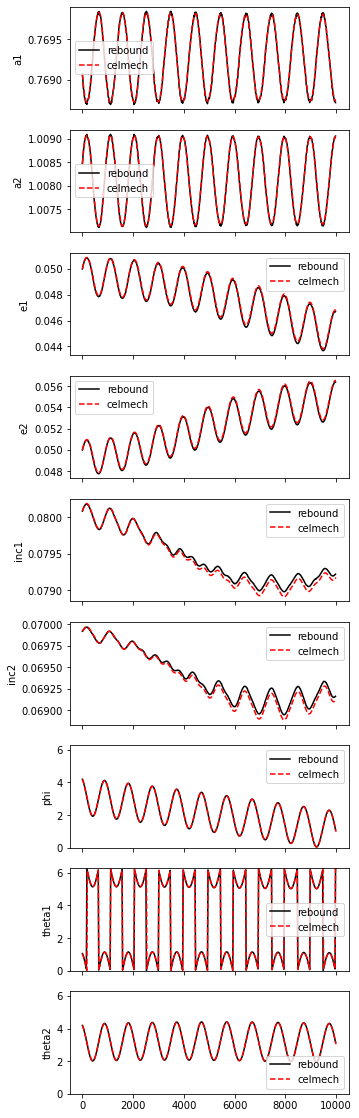

In [9]:
fig,axes = plt.subplots(len(els_res_eqs)-1,1,sharex=True,figsize=(5,20))
time1 = els_res_eqs['times']
time2 = nb_results_by_planet['time']
for i,key in enumerate(els_res_eqs.keys()):
    
    if key=='times':
        continue
    ax = axes[i]
    ax.plot(time2,nb_results_by_planet[key],'k-',label='rebound')
    ax.plot(time1,els_res_eqs[key],'r--',label='celmech')
    ax.legend()
    ax.set_ylabel(key)
    if key[0] == 't' or key[0] == 'p':
        ax.set_ylim(0,2*np.pi)